# Первичная обработка

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 30) # показывать больше колонок
pd.set_option('display.max_columns', 30) # показывать больше колонок

data = pd.read_csv('stud_math.csv')


In [41]:
# Проверим числовые параметры

data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [42]:
# Удаляем колонку "studytime, granular" (хз зачем она нужна)

data.drop(columns=['studytime, granular'], inplace=True)

In [43]:
# Основная масса студентов - в районе 16-18 лет. Удаляем записи 4х учеников, которые значительно старше остальных.
data = data.loc[data.age < 20]
print(data.age.value_counts())

16    104
17     98
18     82
15     82
19     24
Name: age, dtype: int64


In [44]:
# Fedu содержит невалидное значение, равное 40. Можно предположить что это опечатка и имелось ввиду 4, но лучше удалить эту запись.
data = data.loc[data.Fedu < 40]
print(data.Fedu.value_counts())

2.0    103
3.0     96
4.0     88
1.0     76
0.0      2
Name: Fedu, dtype: int64


In [45]:
# Есть запись с невалидным значением famrel (-1) - удаляем
data = data.loc[data.famrel > 0]
print(data.famrel.value_counts())

4.0    168
5.0     90
3.0     59
2.0     16
1.0      7
Name: famrel, dtype: int64


In [46]:
# метод для обреза по iqr с двух сторон
def remove_outliers(df, columns):
    for col in columns:
        if ((df[col].dtype=='float64') | (df[col].dtype=='int64')):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            df = df.loc[df[col].between(q1 - 1.5 * iqr, q3 + 1.5 * iqr)]
    return df

# метод для обреза по iqr сверху
def remove_outliers_top(df, columns):
    for col in columns:
        if ((df[col].dtype=='float64') | (df[col].dtype=='int64')):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            df = df.loc[df[col] < (q3 + 1.5 * iqr)]
    return df

# absenses содержит экстремально высокие значения, стоит обрезать сверху.
data = remove_outliers_top(data, ['absences'])

In [47]:
data.describe()

# Все числовые значения, кроме score, в порядке

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,311.000000,308.000000,311.000000,288.000000,306.000000,294.000000,311.000000,304.000000,303.000000,298.000000,311.000000,306.000000
mean,16.614148,2.733766,2.504823,1.472222,2.049020,0.289116,3.954984,3.223684,3.085809,3.506711,4.356913,51.911765
std,1.180073,1.112805,1.095066,0.717569,0.857493,0.706926,0.911167,0.989699,1.094491,1.373739,4.595012,22.565505
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,45.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,3.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,6.000000,65.000000
max,19.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,18.000000,100.000000


In [48]:
# Изучим пропуски

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      311 non-null    object 
 1   sex         311 non-null    object 
 2   age         311 non-null    int64  
 3   address     300 non-null    object 
 4   famsize     292 non-null    object 
 5   Pstatus     276 non-null    object 
 6   Medu        308 non-null    float64
 7   Fedu        311 non-null    float64
 8   Mjob        296 non-null    object 
 9   Fjob        284 non-null    object 
 10  reason      297 non-null    object 
 11  guardian    285 non-null    object 
 12  traveltime  288 non-null    float64
 13  studytime   306 non-null    float64
 14  failures    294 non-null    float64
 15  schoolsup   303 non-null    object 
 16  famsup      281 non-null    object 
 17  paid        278 non-null    object 
 18  activities  299 non-null    object 
 19  nursery     295 non-null    o

In [49]:
# Заменим пропуски

data.fillna({
    # 'school':'unknown', # Пропусков нет
    # 'sex':'unknown', # Пропусков нет
    'address':'unknown',
    'famsize':'unknown',
    'Pstatus':'unknown',
    'Medu': data.Medu.mean(),
    # 'Fedu': data.Fedu.mean(), # Пропусков нет
    'Mjob':'unknown',
    'Fjob':'unknown',
    'reason':'unknown',
    'guardian':'unknown',
    'traveltime': data.traveltime.mean(),
    'studytime': data.studytime.mean(),
    'failures': data.failures.mean(),
    'schoolsup': 'unknown',
    'famsup': 'unknown',    
    'paid': 'unknown',
    'activities': 'unknown',
    'nursery': 'unknown',
    'higher': 'unknown',
    'internet': 'unknown',
    'romantic': 'unknown',
    # 'famrel': data.famrel.mean(), # Пропусков нет
    'freetime': data.freetime.mean(),
    'goout': data.freetime.mean(),
    'health': data.freetime.mean(),
    # 'absences': data.freetime.mean() # Пропусков нет
    # 'score': 0 # Рассмотрим отдельно
    }, inplace=True)

In [50]:
# Проверим пропуски ещё раз

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      311 non-null    object 
 1   sex         311 non-null    object 
 2   age         311 non-null    int64  
 3   address     311 non-null    object 
 4   famsize     311 non-null    object 
 5   Pstatus     311 non-null    object 
 6   Medu        311 non-null    float64
 7   Fedu        311 non-null    float64
 8   Mjob        311 non-null    object 
 9   Fjob        311 non-null    object 
 10  reason      311 non-null    object 
 11  guardian    311 non-null    object 
 12  traveltime  311 non-null    float64
 13  studytime   311 non-null    float64
 14  failures    311 non-null    float64
 15  schoolsup   311 non-null    object 
 16  famsup      311 non-null    object 
 17  paid        311 non-null    object 
 18  activities  311 non-null    object 
 19  nursery     311 non-null    o

count    306.000000
mean      51.911765
std       22.565505
min        0.000000
25%       45.000000
50%       55.000000
75%       65.000000
max      100.000000
Name: score, dtype: float64


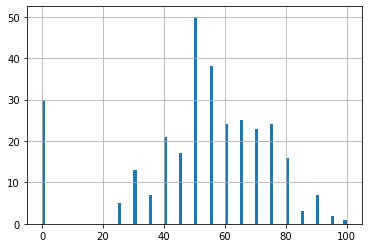

In [51]:
# Проверим основной параметр, по которому мы будем судить учеников - score

data.score.hist(bins=100)
print(data.score.describe())

In [52]:
# Есть пропуски и значения равные 0, в то время как все остальные ученики имеют балл выше 20. Считаем нули и пустые значения нерепрезентативными и удаляем.

data =data.dropna(subset=['score'])
data = data.loc[data.score > 20]

In [53]:
# Изучим номинативные переменные

print(data.school.value_counts())
print(data.sex.value_counts())
print(data.address.value_counts())
print(data.famsize.value_counts())
print(data.Pstatus.value_counts())
print(data.Mjob.value_counts())
print(data.Fjob.value_counts())
print(data.reason.value_counts())
print(data.guardian.value_counts())
print(data.schoolsup.value_counts())
print(data.famsup.value_counts())
print(data.paid.value_counts())
print(data.activities.value_counts())
print(data.nursery.value_counts())
print(data.higher.value_counts())
print(data.internet.value_counts())
print(data.romantic.value_counts())

# Всё в порядке.

GP    244
MS     32
Name: school, dtype: int64
F    144
M    132
Name: sex, dtype: int64
U          207
R           60
unknown      9
Name: address, dtype: int64
GT3        177
LE3         83
unknown     16
Name: famsize, dtype: int64
T          221
unknown     31
A           24
Name: Pstatus, dtype: int64
other       91
services    65
at_home     42
teacher     38
health      26
unknown     14
Name: Mjob, dtype: int64
other       143
services     68
unknown      24
teacher      19
at_home      12
health       10
Name: Fjob, dtype: int64
course        91
reputation    77
home          68
other         27
unknown       13
Name: reason, dtype: int64
mother     177
father      62
unknown     24
other       13
Name: guardian, dtype: int64
no         231
yes         37
unknown      8
Name: schoolsup, dtype: int64
yes        149
no         100
unknown     27
Name: famsup, dtype: int64
no         132
yes        114
unknown     30
Name: paid, dtype: int64
yes        138
no         127
unknown 

In [54]:
# В итоге у нас есть 276 записей для анализа

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      276 non-null    object 
 1   sex         276 non-null    object 
 2   age         276 non-null    int64  
 3   address     276 non-null    object 
 4   famsize     276 non-null    object 
 5   Pstatus     276 non-null    object 
 6   Medu        276 non-null    float64
 7   Fedu        276 non-null    float64
 8   Mjob        276 non-null    object 
 9   Fjob        276 non-null    object 
 10  reason      276 non-null    object 
 11  guardian    276 non-null    object 
 12  traveltime  276 non-null    float64
 13  studytime   276 non-null    float64
 14  failures    276 non-null    float64
 15  schoolsup   276 non-null    object 
 16  famsup      276 non-null    object 
 17  paid        276 non-null    object 
 18  activities  276 non-null    object 
 19  nursery     276 non-null    o

# Корреляционный анализ

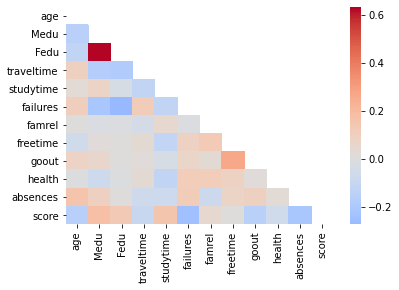

In [71]:
# Изучим корреляцию данных

corr = data.corr()
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0)

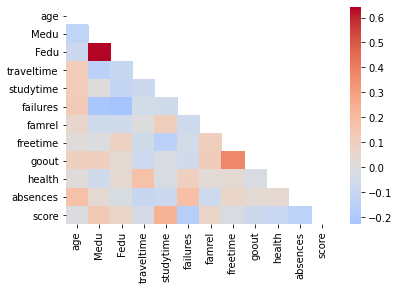

In [78]:
# Посмотрим как менется картина в зависимости от пола
# Интересно, что путь до школы почти не влияет на кол-во проблем у девочек

sns.heatmap(data[data.sex == 'F'].corr(), mask=mask, cmap="coolwarm", center=0)

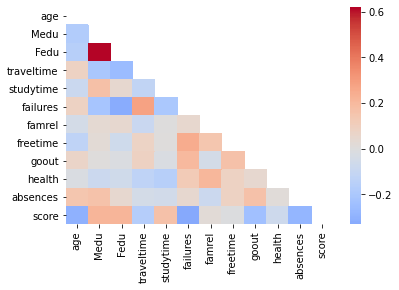

In [77]:

sns.heatmap(data[data.sex == 'M'].corr(), mask=mask, cmap="coolwarm", center=0)

In [62]:
# Посмотрим какие числовые параметры влияют на балл

data.corrwith(data.score)

age          -0.160791
Medu          0.178112
Fedu          0.135365
traveltime   -0.094680
studytime     0.158110
failures     -0.242996
famrel        0.049027
freetime      0.008571
goout        -0.154913
health       -0.060580
absences     -0.208069
score         1.000000
dtype: float64

## Наблюдения после сопоставления числовых параметров

* Супруги часто имеют схожий уровень образования.
* При этом, чем выше образование родителей, тем лучшие результаты показывает ребёнок на экзамене по математике и является менее проблемным.
* С возрастом, растёт количество пропусков и проблем, причиняемых ребёнком.
* С возрастом идёт понижение среднего балла, но это скорей всего потому что  у старших детей в данной выборке - менее образованные родители.
* Чем дольше ребёнок добирается до школы - тем больше вероятность причинения проблем по пути. И взрослые дети добираются до школы дольше - возможно потому что порой приоритезируют приключения. Зато такие дети более здоровые т.к. проводят больше времени на улице. 
* Числовые параметры, влияющие на балл:
    * Дети с образованными родителями - более успешные в математике, видимо потому что им помогают с уроками дома
    * Дети, которые больше занимаются, имеют более высокие баллы
    * Проблемные и гуляющие дети имеют более низкий балл по математике

# Анализ номинативных переменных

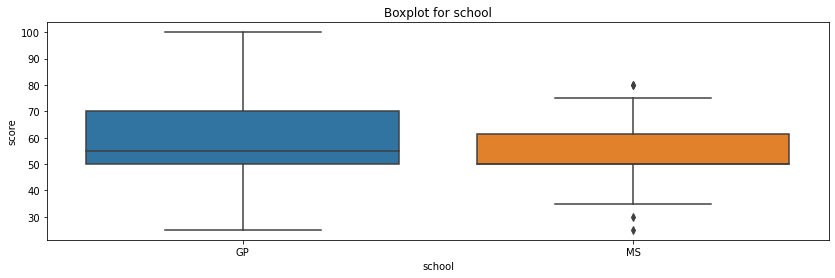

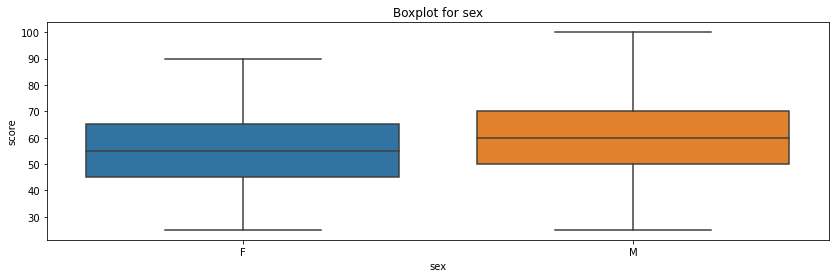

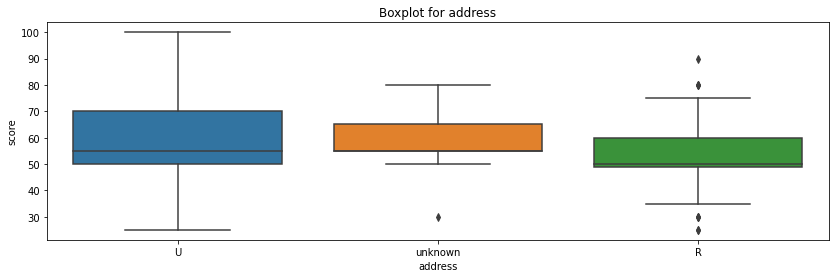

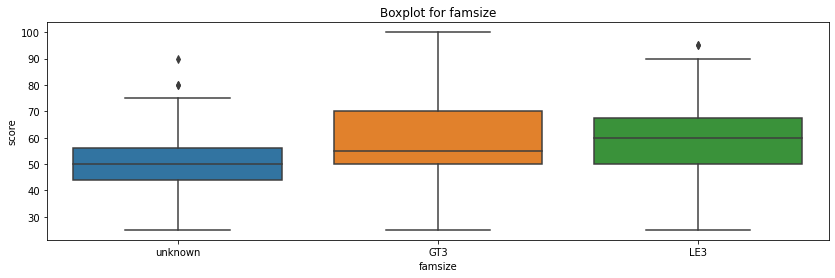

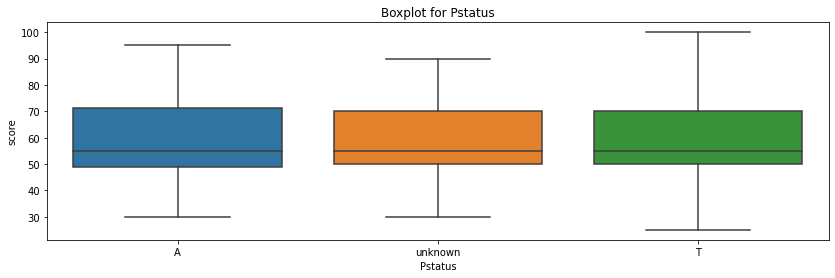

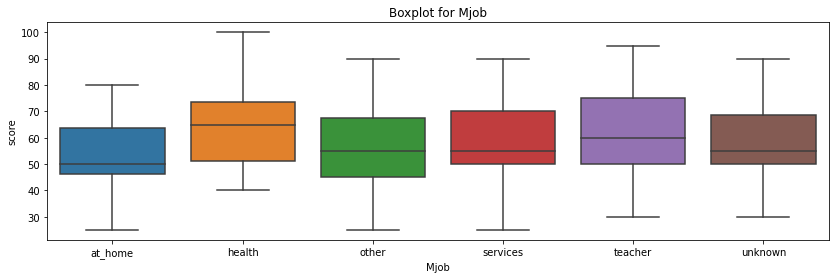

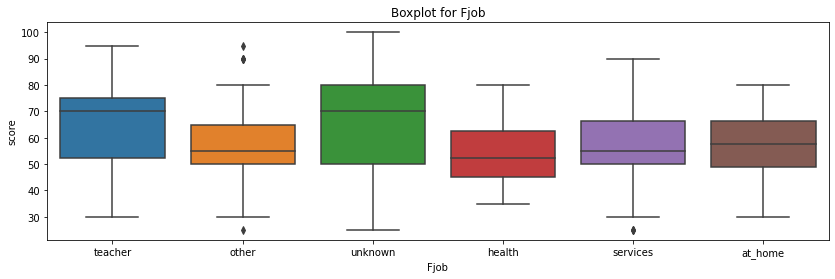

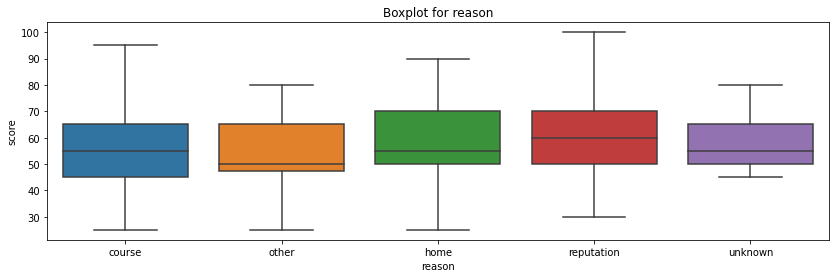

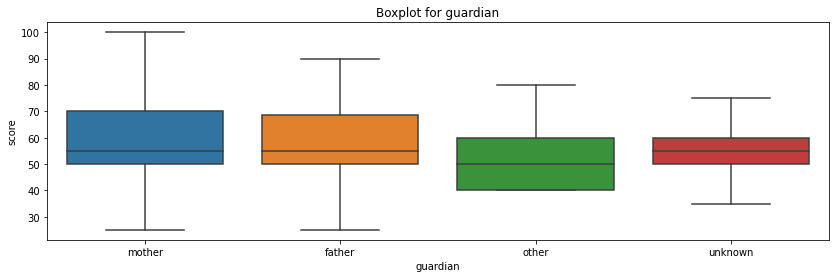

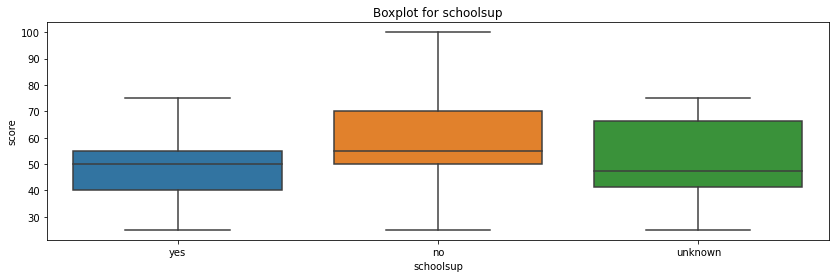

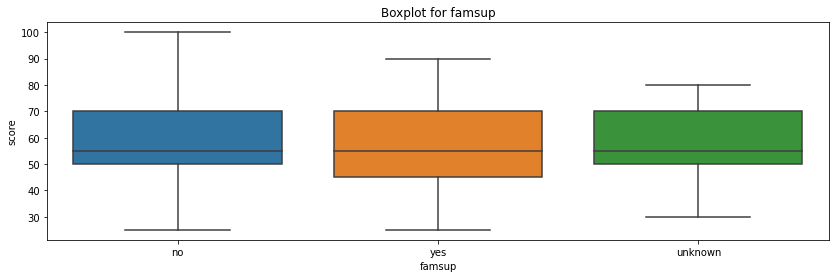

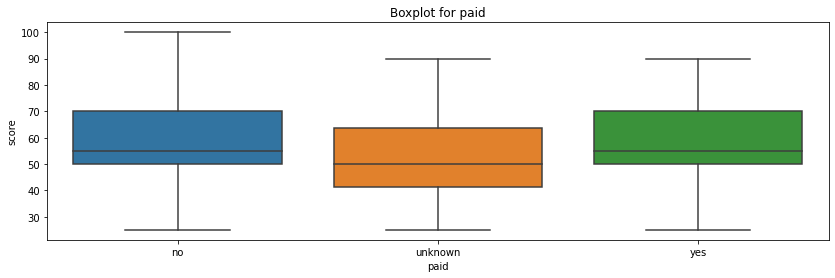

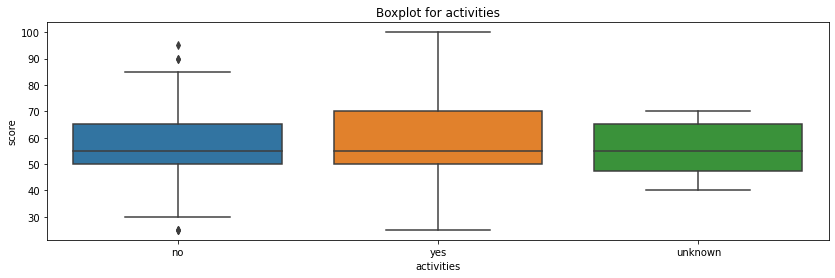

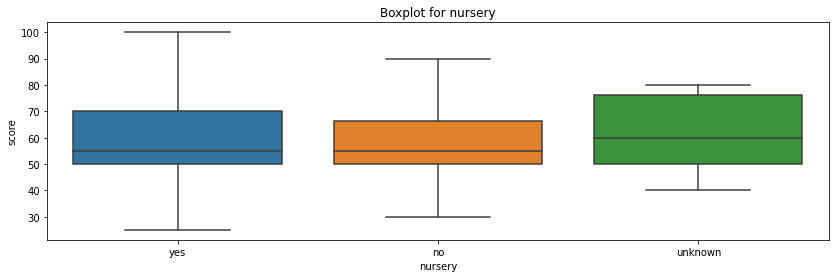

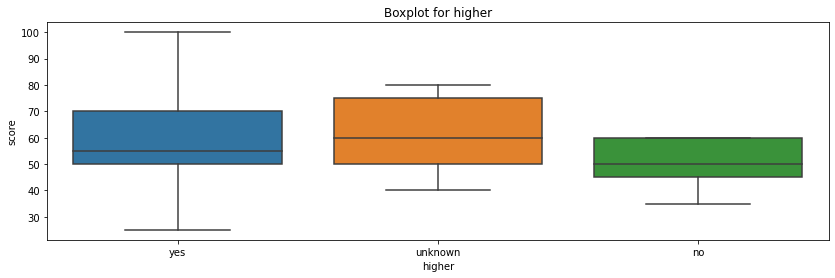

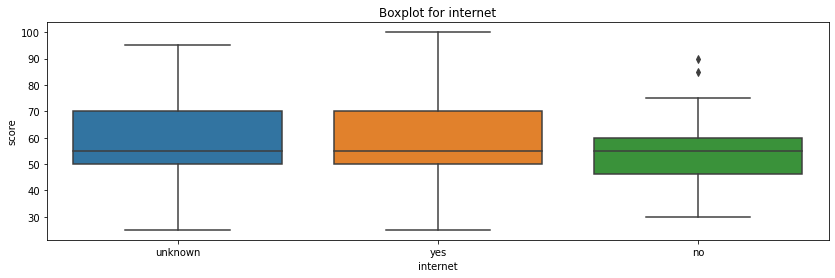

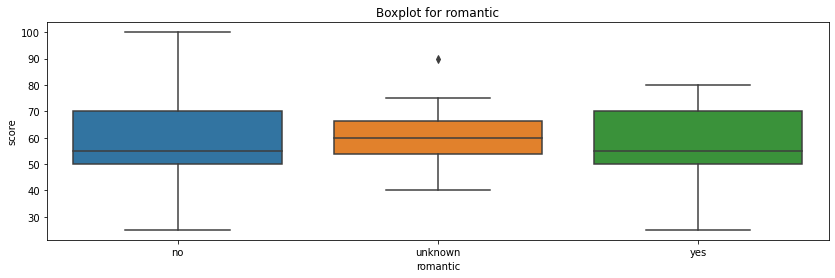

In [89]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks()
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in [
    'school', 
    'sex', 
    'address', 
    'famsize', 
    'Pstatus',
    'Mjob',
    'Fjob',
    'reason',
    'guardian',
    'schoolsup',
    'famsup',
    'paid',
    'activities',
    'nursery',
    'higher',
    'internet',
    'romantic']:
    get_boxplot(col)

# Выводы